# 2019 2nd ML month with KaKR

### 캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction

AIFFEL 기초다지기 node 10

- 중간에 타깃을 로그스케일링 하는 코드가 있는데 이 부분이 LMS 노드 앞쪽 코드와 호환이 안 되어 시간이 많이 들었다.
- Featr. Eng.는 최소한으로 넣었다. 이 플젝의 목표는 튜닝에 있다.
- 아래는 점수
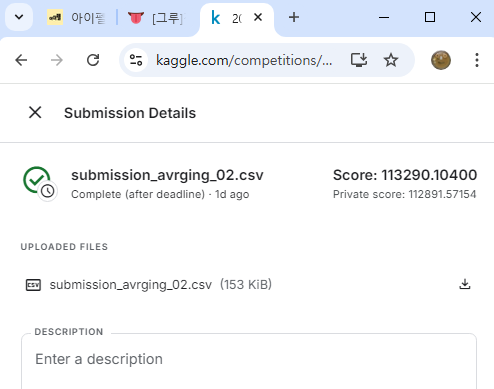

In [206]:
# 주피터 NB 시각화 설정
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [207]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
data_dir = "~/aiffel/kaggle_kakr_housing/data"

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

In [209]:
data = pd.read_csv(train_data_path) # train 파일
sub = pd.read_csv(sub_data_path) #test 파일
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


### 전처리

In [210]:
y = data['price']
del data['price']

In [211]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [212]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

In [213]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [214]:
sub_id = data['id'][train_len:]
del data['id']

__추가된 전처리: 재건축 연도__

In [215]:
train_len

15035

In [216]:
data['yr_renovated'] = data[['yr_renovated', 'yr_built']].apply(
            lambda i: np.max(i), axis=1)

min(data['yr_renovated'])

1900

__추가된 전처리: 우편번호 처리__

In [217]:
from collections import Counter

In [218]:
zipcodes=Counter(data['zipcode'])
len(zipcodes)

70

In [219]:
onehot_zipcode = pd.get_dummies(data['zipcode'],prefix='z')
data = pd.concat([data, onehot_zipcode], axis=1)
del data['zipcode']

In [220]:
train = data.iloc[:train_len,:]
X_sub = data.iloc[train_len:,:]

In [221]:
# 치우친 분포의 칼럼 스케일링
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot',
'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [222]:
# 예측 타겟벡터('price')도 log로 스케일링
y_log = np.log1p(y)

In [223]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  int64  
 17  sqft_lot15     15035 non-null  int64  
 18  z_9800

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,z_98146,z_98148,z_98155,z_98166,z_98168,z_98177,z_98178,z_98188,z_98198,z_98199
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,1,0,0,0
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,1,0


In [151]:
X_sub.info()
X_sub.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 0 to 6467
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  lat            6468 non-null   float64
 15  long           6468 non-null   float64
 16  sqft_living15  6468 non-null   int64  
 17  sqft_lot15     6468 non-null   int64  
 18  98001   

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,...,0,0,0,0,0,0,0,0,0,0
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,...,0,0,0,0,0,0,0,0,0,0
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,...,1,0,0,0,0,0,0,0,0,0
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0


### 모델링

In [152]:
random_state=2024
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(n_estimators=100, max_depth=40,
                                     random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [15]:
# KFold Cross-validation 도입
def get_cv_score(models, x, y, n_splits=5):
    kfold = KFold(n_splits).get_n_splits(x.values)
    
    for m in models:
        model_name = m.__class__.__name__ # 모델 이름
        CV_score = np.mean(
                cross_val_score(m, X=x.values, y=y, cv=kfold) )
        print(f"Model: {model_name}, CV score:{CV_score:.4f}")


In [28]:
# R-square 값 가장 나은 모델(price 값): XGBRegressor 0.8861
# R-square 값 가장 나은 모델(price의 log 값): GradientBoostingRegressor 0.8796
get_cv_score(models, train, y_log)

Model: GradientBoostingRegressor, CV score:0.8796
Model: XGBRegressor, CV score:0.8973
Model: LGBMRegressor, CV score:0.9025
Model: RandomForestRegressor, CV score:0.8858


In [165]:
def rmse(y_test, y_pred, log_trgt=False):
    # 로그 스케일 타겟 복구
    if log_trgt: 
        y_test=np.expm1(y_test); y_pred=np.expm1(y_pred)

    return np.sqrt(mean_squared_error(y_test, y_pred))

In [166]:
def get_scores(models, train, y, random_state, log_trgt=False):
    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(
                train, y, test_size=0.2, random_state=random_state)
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)
     
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred, log_trgt)
  
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE')
    return score_df

In [167]:
# RMSE 값 가장 나은 모델: XGBRegressor 155907.601219
get_scores(models, train, y_log, random_state, log_trgt=True)

,RMSE
XGBRegressor,156499.114010
LGBMRegressor,162381.034637
RandomForestRegressor,163415.701813
GradientBoostingRegressor,172812.697825


### 그리드 탐색

In [168]:
from sklearn.model_selection import GridSearchCV

In [183]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):

    grid_model = GridSearchCV(model, param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    
    results = pd.DataFrame(grid_model.cv_results_['params'])
    results['score'] = grid_model.cv_results_['mean_test_score']
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results.sort_values('RMSLE', inplace=True)
    
    return results

__XGBRegressor 그리드 탐색__

In [245]:
# LMS 노드 예제 그대로
param_grid = {
    'n_estimators': [100, 110, 120],
#     'max_depth': [4,5,6],
}

In [246]:
model = xgb.XGBRegressor(max_depth=5, #n_estimators=100, 
                          random_state=random_state)

|	max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|5|	120	|	-0.027876|	0.166961|

|	max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|5|	90|	-0.028101|	0.167634|

|	max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|3|	100|	-0.028905|	0.170014|

|	max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|10|	100|	-0.029824|	0.172696|

In [247]:
# y('price')에 로그를 취한 값으로 학습
srch_rslt = my_GridSearch(model, train, y_log, param_grid, verbose=2, n_jobs=5)
srch_rslt

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


,n_estimators,score,RMSLE
2,120,-0.027876,0.166961
1,110,-0.027892,0.167008
0,100,-0.027945,0.167169


__LGBMRegressor 그리드 탐색__

In [195]:
# LMS 노드 예제 그대로
param_grid = {
    'n_estimators': [200, 400, 800],
#     'max_depth': [40, 80],
}

In [196]:
model = lgb.LGBMRegressor(n_estimators=100, max_depth=40,
                          random_state=random_state)

In [197]:
# y('price')에 로그를 취한 값으로 학습
srch_rslt = my_GridSearch(model, train, y_log, param_grid,
                                          verbose=2, n_jobs=5)
srch_rslt

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,n_estimators,score,RMSLE
0,200,-0.026135,0.161662
1,400,-0.026172,0.161777
2,800,-0.026610,0.163126


__RandomForestRegressor 그리드 탐색__

In [248]:
# RandomForestRegressor 모델도 공통으로 갖는 파라미터들
param_grid = {
    'n_estimators': [70, 80],
    'max_depth': [20, 30, 40 ],
}

In [249]:
model = RandomForestRegressor(#n_estimators=100, max_depth=40,
                          random_state=random_state)

|max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|40|	80|	-0.031541|	0.177597|

|max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|60|	60|	-0.031762|	0.178219|

|max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|10|	100|	-0.034921|	0.186872|

|max_depth|	n_estimators|	score|	RMSLE|
|---|---|---|---|
|6|	30|	-0.050642	|	0.225037|

In [250]:
# y('price')에 로그를 취한 값으로 학습
srch_rslt = my_GridSearch(model, train, y_log, param_grid,
                                      verbose=2, n_jobs=3)
srch_rslt

[CV] END .......................max_depth=2, n_estimators=20; total time=   5.1s
[CV] END .......................max_depth=2, n_estimators=60; total time=  13.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=  23.1s
[CV] END .......................max_depth=3, n_estimators=20; total time=   7.2s
[CV] END .......................max_depth=3, n_estimators=20; total time=   5.5s
[CV] END .......................max_depth=3, n_estimators=60; total time=  20.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=  35.9s
[CV] END .......................max_depth=8, n_estimators=20; total time=  14.1s
[CV] END .......................max_depth=8, n_estimators=60; total time=  55.8s
[CV] END ......................max_depth=8, n_estimators=100; total time= 1.7min
[CV] END .......................max_depth=4, n_estimators=70; total time=  35.8s
[CV] END .......................max_depth=4, n_estimators=80; total time=  36.2s
[CV] END ...................

,max_depth,n_estimators,score,RMSLE
5,40,80,-0.031541,0.177597
3,30,80,-0.031596,0.177751
1,20,80,-0.031597,0.177755
4,40,70,-0.031642,0.177883
2,30,70,-0.031689,0.178013
0,20,70,-0.031714,0.178085


[CV] END .......................max_depth=2, n_estimators=20; total time=   5.6s
[CV] END .......................max_depth=2, n_estimators=60; total time=  15.1s
[CV] END ......................max_depth=2, n_estimators=100; total time=  25.7s
[CV] END .......................max_depth=3, n_estimators=60; total time=  19.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=  33.7s
[CV] END .......................max_depth=8, n_estimators=20; total time=  16.3s
[CV] END .......................max_depth=8, n_estimators=60; total time=  58.7s
[CV] END ......................max_depth=8, n_estimators=100; total time= 1.9min
[CV] END .......................max_depth=4, n_estimators=70; total time=  33.4s
[CV] END .......................max_depth=4, n_estimators=80; total time=  35.8s
[CV] END .......................max_depth=4, n_estimators=90; total time=  42.9s
[CV] END .......................max_depth=5, n_estimators=70; total time=  48.3s
[CV] END ...................

In [257]:
# 그리드 서치 결과 예측값
model1 = xgb.XGBRegressor(max_depth=5, n_estimators=120, random_state=random_state)
model2 = lgb.LGBMRegressor(max_depth=40, n_estimators=200, random_state=random_state)
model3 = RandomForestRegressor(max_depth=40, n_estimators=80, random_state=random_state)
# model.fit(train, y)
# y_pred = model.predict(X_sub)

In [193]:
def AveragingBlending(models, x, y, sub_x, log_trgt=False):
    for m in models : m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models ])
    
    # 로그 스케일링 한 타겟일 경우
    if log_trgt: predictions = np.expm1(predictions)
    
    return np.mean(predictions, axis=1)

### 캐글 제출 폼 만들기

In [175]:
def save_submission(model, train, y, test, model_name, rmsle, log_trgt=False):
    model.fit(train, y)
    prediction = model.predict(test)
    # 로그 스케일링 한 타겟일 경우
    if log_trgt: prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path ='{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print("saved to, "+submission_csv_path)
    return

In [258]:
# 에버리징 예측값
y_pred_avg = AveragingBlending([model1,model2,model3],
                               train, y_log, X_sub, True)

In [259]:
# 에버리징 결과값 .csv 저장
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred_avg})
submission_path = join(data_dir, 'submission_avrging_02.csv')
sub.to_csv(submission_path, index=False)

In [42]:
# 그리드 서치 방법 결과값 .csv 저장
save_submission(
    model1, train, y_log, X_sub,
    'LGBMRegressor', rmsle='0.161662', log_trgt=True)

saved to, /aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBRegressor_RMSLE_0.174210.csv


In [252]:
# 그리드 서치 방법 결과값 .csv 저장
save_submission(
    model2, train, y_log, X_sub,
    'XGBRegressor', rmsle='0.166961', log_trgt=True)

saved to, /aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBRegressor_RMSLE_0.166961.csv


In [254]:
# 그리드 서치 방법 결과값 .csv 저장
save_submission(
    model3, train, y_log, X_sub,
    'RandomForestRegressor', rmsle='0.177597', log_trgt=True)

saved to, /aiffel/aiffel/kaggle_kakr_housing/data/submission_RandomForestRegressor_RMSLE_0.177597.csv
